<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Reseau_GRU_Avec_Attention_Hierarchique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans ce carnet nous allons mettre en place un modèle à réseau de neurones récurrent de type GRU associé à une **couche d'attention hiérarchique** comprenant un **vecteur contexte** pour réaliser des prédictions sur notre série temporelle.  

In [99]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# Création de la série temporelle et du dataset pour l'entrainement

In [100]:
# Fonction permettant d'afficher une série temporelle
def affiche_serie(temps, serie, format="-", debut=0, fin=None, label=None):
    plt.plot(temps[debut:fin], serie[debut:fin], format, label=label)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Fonction permettant de créer une tendance
def tendance(temps, pente=0):
    return pente * temps

# Fonction permettant de créer un motif
def motif_periodique(instants):
    return (np.where(instants < 0.4,                            # Si les instants sont < 0.4
                    np.cos(instants * 2 * np.pi),               # Alors on retourne la fonction cos(2*pi*t)
                    1 / np.exp(3 * instants)))                  # Sinon, on retourne la fonction exp(-3t)

# Fonction permettant de créer une saisonnalité avec un motif
def saisonnalite(temps, periode, amplitude=1, phase=0):
    """Répétition du motif sur la même période"""
    instants = ((temps + phase) % periode) / periode            # Mapping du temps =[0 1 2 ... 1460] => instants = [0.0 ... 1.0]
    return amplitude * motif_periodique(instants)

# Fonction permettant de générer du bruit gaussien N(0,1)
def bruit_blanc(temps, niveau_bruit=1, graine=None):
    rnd = np.random.RandomState(graine)
    return rnd.randn(len(temps)) * niveau_bruit

# Fonction permettant de créer un dataset à partir des données de la série temporelle
# au format X(X1,X2,...Xn) / Y(Y1,Y2,...,Yn)
# X sont les données d'entrées du réseau
# Y sont les labels
def prepare_dataset_XY_Paquets(serie, taille_fenetre, nbr_sequences, batch_size, buffer_melange):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre*nbr_sequences+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre*nbr_sequences+1))
#  dataset = dataset.shuffle(buffer_melange)
  dataset = dataset.map(lambda x: (x[:-1], x[-1:]))
#  dataset = dataset.map(lambda x,y: [[x[0:10],x[10:20]],y])
  dataset = dataset.map(lambda x,y: [[x[0:5],x[5:10],x[10:15],x[15:20]],y])
#  dataset = dataset.map(lambda x,y: [[x[0:1],x[1:2],x[2:3],x[3:4],x[4:5],x[5:6],x[6:7],x[7:8],x[8:9],x[9:10]],y])
  dataset = dataset.batch(batch_size,drop_remainder=True)
  return dataset



# Création de la série temporelle
temps = np.arange(4 * 365)                # temps = [0 1 2 .... 4*365] = [0 1 2 .... 1460]
amplitude = 40                            # Amplitude de la la saisonnalité
niveau_bruit = 5                          # Niveau du bruit
offset = 10                               # Offset de la série

serie = offset + tendance(temps, 0.1) + saisonnalite(temps, periode=365, amplitude=amplitude) + bruit_blanc(temps,niveau_bruit,graine=40)

temps_separation = 1000

# Extraction des temps et des données d'entrainement
temps_entrainement = temps[:temps_separation]
x_entrainement = serie[:temps_separation]

# Exctraction des temps et des données de validation
temps_validation = temps[temps_separation:]
x_validation = serie[temps_separation:]

In [101]:
# Cration du dataset
Nbr_Sequences = 4
taille_fenetre = 5
glissement = 5
batch_size = 32
buffer_melange = 2000

# Création du dataset X,Y
dataset = prepare_dataset_XY_Paquets(x_entrainement,taille_fenetre,Nbr_Sequences, batch_size, buffer_melange)

# Création du dataset X,Y de validation
dataset_Val = prepare_dataset_XY_Paquets(x_validation,taille_fenetre,Nbr_Sequences, batch_size, buffer_melange)

In [ ]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element)

30
(<tf.Tensor: shape=(32, 10, 1), dtype=float64, numpy=
array([[[46.96226151],
        [49.4633915 ],
        [46.75326424],
        [54.89024639],
        [41.08320704],
        [48.01691488],
        [61.84928451],
        [52.85399917],
        [53.97263304],
        [55.69857884]],

       [[49.4633915 ],
        [46.75326424],
        [54.89024639],
        [41.08320704],
        [48.01691488],
        [61.84928451],
        [52.85399917],
        [53.97263304],
        [55.69857884],
        [50.67916977]],

       [[46.75326424],
        [54.89024639],
        [41.08320704],
        [48.01691488],
        [61.84928451],
        [52.85399917],
        [53.97263304],
        [55.69857884],
        [50.67916977],
        [51.67479132]],

       [[54.89024639],
        [41.08320704],
        [48.01691488],
        [61.84928451],
        [52.85399917],
        [53.97263304],
        [55.69857884],
        [50.67916977],
        [51.67479132],
        [53.29101145]],

       [[41.083

In [ ]:
dataset2 = dataset.batch(32)
print(len(list(dataset2.as_numpy_iterator())))
for element in dataset2.take(1):
  print(element)

In [ ]:
debut = 0
for i in range(0,Nbr_Sequences+2):
  print(serie[debut:debut+taille_fenetre])
  debut = debut+taille_fenetre

In [102]:
# Calcul de la moyenne et de l'écart type de la série
mean = tf.math.reduce_mean(serie)
std = tf.math.reduce_std(serie)
print(mean.numpy())
print(std.numpy())

# Normalise les données
Serie_Normalisee = (serie-mean)/std
print(tf.math.reduce_mean(Serie_Normalisee).numpy())
print(tf.math.reduce_std(Serie_Normalisee).numpy())

# Affiche les valeurs max et min
min = tf.math.reduce_min(Serie_Normalisee)
max = tf.math.reduce_max(Serie_Normalisee)
print(min)
print(max)

90.49378905192393
43.81927756886552
2.6736603798507197e-16
1.0
tf.Tensor(-2.3143242074901043, shape=(), dtype=float64)
tf.Tensor(1.7934775069770135, shape=(), dtype=float64)


In [103]:
# Extraction des temps et des données d'entrainement
x_entrainement_norm = Serie_Normalisee[:temps_separation]
x_validation_norm = Serie_Normalisee[temps_separation:]

# Création du dataset X,Y
dataset_norm = prepare_dataset_XY_Paquets(x_entrainement_norm,taille_fenetre,Nbr_Sequences, batch_size, buffer_melange)

# Création du dataset X,Y de validation
dataset_Val_norm = prepare_dataset_XY_Paquets(x_validation_norm,taille_fenetre,Nbr_Sequences, batch_size, buffer_melange)

# Création du modèle GRU avec couche d'attention possédant un vecteur de contexte

**1. Création du réseau et adaptation des formats d'entrée et de sortie**

Sous forme de shéma, notre réseau est donc le suivant :


<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/Attention_VecteurContexte1.png?raw=true" width="1200"> 

In [ ]:
# Remise à zéro de tous les états générés par Keras
tf.keras.backend.clear_session()

On créé une classe dérivée de la classe [Layer](https://keras.io/api/layers/base_layer/#layer-class) de Keras. Les méthodes utilisées sont les suivantes :  
 - [build](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#build) : Permet de créer les variables utilisées par la couche (commes les poids et les offsets)
 - [call](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#call) : Permet d'implanter la logique de la couche

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/Attention_VecteurContexte2.png?raw=true" width="1200"> 

Parmi les nouvelles fonctions de Tensorflow et de Keras utilisées, on trouve :
- [transpose](https://www.tensorflow.org/api_docs/python/tf/transpose) : Permet de transposer un tenseur et éventuellement de reconstituer l'ordre des axes avec l'argument `perm`
- [add_weight](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#add_weight) : Méthode de la classe Layers de Keras, qui permet d'ajouter un paramètre (poids et offset ou autre) qui sera une variable mémoire pour la couche construite. 


In [95]:
# Classe d'attention niveau sous-sequence
# Applique les poids d'attention sur les vecteurs de la couche récurrente

# Importe le Backend de Keras
from keras import backend as K

# Définit une nouvelle classe Couche_Attention
# Héritée de la classe Layer de Keras

class Couche_Attention(tf.keras.layers.Layer):
  # Fonction d'initialisation de la classe d'attention
  def __init__(self,dim_att):
    self.dim_att = dim_att          # Dimension du vecteur d'attention
    super().__init__()              # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.W = self.add_weight(shape=(self.dim_att,input_shape[2]),initializer="normal",name="W")
    self.b = self.add_weight(shape=(self.dim_att,1),initializer="zeros",name="b")
    self.u = self.add_weight(shape=(self.dim_att,1),initializer="normal",name="u")
    super().build(input_shape)        # Appel de la méthode build()

  # Définit la logique de la couche d'attention
  # Arguments :   x : Tenseur d'entrée de dimension (None, nbr_v,dim)
  def call(self,x):
    # Calcul de la matrice XH contenant les
    # représentations cachées des vecteurs
    # issus de la couche GRU
    x = tf.transpose(x,perm=[0,2,1])          # x = (None, dim,20)
    Xh = K.dot(self.W,x)                      # Xh = (dim_att,None,20)
    Xh = tf.transpose(Xh,perm=[1,0,2])        # Xh = (None, dim_att,20)
    Xh = Xh + tf.expand_dims(self.b,axis=0)   # Xh = (None, dim_att,20) + (None, dim_att,1)
    Xh = K.tanh(Xh)                           # Xh = (None, dim_att,20)

    # Calcul des poids d'attention normalisés
    Xh = tf.transpose(Xh,perm=[0,2,1])        # Xh = (None,20,dim_att)
    a = K.dot(Xh,self.u)                      # a = (None,20,1)
    a = tf.keras.activations.softmax(a,axis=1)

    # Calcul du vecteur d'attention
    xa = tf.multiply(Xh,a)                    # xa = (None,20,dim)
    sortie = K.sum(xa,axis=1)                 # sortie = (None,40)
    return sortie

  def compute_output_shape(self,input_shape):
    return(input_shape[0],input_shape[2])


In [96]:
# Classe d'attention niveau sequence

# Importe le Backend de Keras
from keras import backend as K

# Définit une nouvelle classe Couche_Attention
# Héritée de la classe Layer de Keras

class Couche_Attention_Sequence(tf.keras.layers.Layer):
  # Fonction d'initialisation de la classe d'attention
  def __init__(self,dim_att):
    self.dim_att = dim_att          # Dimension du vecteur d'attention
    super().__init__()              # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    super().build(input_shape)        # Appel de la méthode build()

  # Définit la logique de la couche d'attention
  # Arguments :   x : Tenseur d'entrée de dimension (batch_size, Nbr_sequences,taille_fenetre)
  def call(self,x):
    s_gru = tf.keras.layers.TimeDistributed(tf.keras.layers.GRU(dim_GRU,return_sequences=True))(input)
    print(s_gru)
    return 1

  def compute_output_shape(self,input_shape):
    return()


In [247]:
# 1 sous_sequence : XXXXX (5 valeurs)
# 1 sequence = 4 sous_sequences : |ss1|ss2|ss3|ss4| = |XXXXX|XXXXX|XXXXX|XXXXX|

# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

# Encodeur des sous-séquences
# Entrée : (None,5) : 5 valeurs de la sous-sequence
dim_GRU = 10
entree_sous_sequence = tf.keras.layers.Input(shape=(taille_fenetre))                  # (None,5)

s = tf.keras.layers.Lambda(Traitement_Entrees)(entree_sous_sequence)                  # (None,5) => (None,5,1)
s = tf.keras.layers.GRU(dim_GRU,return_sequences=True)(s)                             # (None,5,1) => (None,5,10)
s = Couche_Attention(dim_GRU)(s)                                                      # (None,5,10) => (None,10)
encodeur_sous_sequence = tf.keras.Model(entree_sous_sequence, s)
encodeur_sous_sequence.summary()


# Encodeur des séquences
dim_GRU = 40
entree_sequence = tf.keras.layers.Input(shape=(Nbr_Sequences,taille_fenetre))       # (None,4,5)
s = tf.keras.layers.TimeDistributed(encodeur_sous_sequence)(entree_sequence)        # (None,4,5) => (None,4,10) (TimeStep = 4 : (None,5) envoyé)
print(s.shape)




Model: "model_227"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_381 (InputLayer)       [(None, 5)]               0         
_________________________________________________________________
lambda_211 (Lambda)          (None, 5, 1)              0         
_________________________________________________________________
gru_232 (GRU)                (None, 5, 10)             390       
_________________________________________________________________
couche__attention_142 (Couch (None, 10)                120       
Total params: 510
Trainable params: 510
Non-trainable params: 0
_________________________________________________________________
(None, 4, 10)


In [204]:
entree = tf.keras.layers.Input(shape=(1,1,1,Nbr_Sequences,taille_fenetre,1))
print(entree.shape)
s = tf.keras.layers.TimeDistributed(encodeur_sous_sequence)(entree) 

(None, 1, 1, 1, 4, 5, 1)


In [184]:
# 1 sous_sequence : XXXXX (5 valeurs)
# 1 sequence = 4 sous_sequences : |ss1|ss2|ss3|ss4| = |XXXXX|XXXXX|XXXXX|XXXXX|

# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

# Encodeur des sous-séquences
dim_GRU = 10
entree_sous_sequence = tf.keras.layers.Input(shape=(1,1,Nbrtaille_fenetre),batch_size=4)                        # IN : (1,1,4,5,1)
s = tf.keras.layers.Lambda(Traitement_Entrees)(entree_sous_sequence)                                     # IN : (4,5)    ; OUT : (4,5,1)
s = tf.keras.layers.GRU(dim_GRU,return_sequences=True)(s)                                                # IN : (4,5,1)  ; OUT : (4,5,10)
att_s = Couche_Attention(dim_GRU)(s)                                                                     # IN : (4,5,10) ; OUT : (4,10)
encodeur_sous_sequence = tf.keras.Model(entree_sous_sequence, att_s)                                     # IN : (4,5)    ; OUT : (4,10)
encodeur_sous_sequence.summary()

# Encodeur des séquences
dim_GRU = 40
entree_sequence = tf.keras.layers.Input(shape=(1,Nbr_Sequences, taille_fenetre))              # IN : (None,1,4,5) ;
entree_sequence2 = tf.squeeze(entree_sequence,axis=1)                                         # IN : (None,1,4,5) ; OUT : (None,4,5)
s = tf.keras.layers.TimeDistributed(encodeur_sous_sequence)(entree_sequence2)                 # IN : (None,4,5)   ; OUT : (1,4,10)
s = tf.squeeze(s,axis=0)                                                                      # IN : (1,4,10)     ; OUT : (4,10)
s = tf.keras.layers.Lambda(Traitement_Entrees)(s)                                             # IN : (4,10)       ; OUT : (4,10,1)
s = tf.keras.layers.GRU(dim_GRU,return_sequences=True)(s)                                     # IN : (4,10,1)     ; OUT : (4,10,40)
encodeur_sequence = tf.keras.Model(entree_sequence, s)                                        # IN : (None,4,5)   ; OUT : (4,10,40)
encodeur_sequence.summary()

# Modèle global
entree = tf.keras.layers.Input(shape=(Nbr_Sequences, taille_fenetre), batch_size=32)            # IN : (32,4,5)   
entree = tf.expand_dims(entree,axis=0)
entree = tf.expand_dims(entree,axis=1)

print(entree.shape)
sortie = tf.keras.layers.TimeDistributed(encodeur_sequence)(entree)

Model: "model_188"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_296 (InputLayer)       [(4, 5)]                  0         
_________________________________________________________________
lambda_194 (Lambda)          (4, 5, 1)                 0         
_________________________________________________________________
gru_196 (GRU)                (4, 5, 10)                390       
_________________________________________________________________
couche__attention_118 (Couch (4, 10)                   120       
Total params: 510
Trainable params: 510
Non-trainable params: 0
_________________________________________________________________
Model: "model_189"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_297 (InputLayer)       [(None, 1, 4, 5)]         0         
________________________________________

ValueError: ignored

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(lr=1e-8)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
encodeur_sequence.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = encodeur_sequence.fit(dataset_norm,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

In [16]:
entree_sequence[0][0].shape

TensorShape([5])

In [ ]:
dim_GRU = 40

# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)


sentence_input = tf.keras.layers.Input(shape=(Nbr_Sequences,))
s1 = tf.keras.layers.Lambda(Traitement_Entrees)(sentence_input)
s2 = tf.keras.layers.GRU(dim_GRU,return_sequences=True)(s1)
attn_word = Couche_Attention(dim_GRU)(s2)
sentenceEncoder = tf.keras.Model(sentence_input, attn_word)

paquets = tf.keras.layers.Input(shape=(1,))
s = sentenceEncoder(paquets)
s = tf.keras.layers.GRU(dim_GRU,return_sequences=True)(tf.expand_dims(s,axis=-1))
attn_sent = Couche_Attention(dim_GRU)(s)
s = tf.keras.layers.Dense(1)(attn_sent)





In [43]:
dim_GRU = 10

# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

model = tf.keras.Sequential()

model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Lambda(Traitement_Entrees), input_shape = (Nbr_Sequences, taille_fenetre),batch_size=batch_size))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.GRU(dim_GRU,return_sequences=True)))
model.add(tf.keras.layers.TimeDistributed(Couche_Attention(dim_GRU)))
model.add(tf.keras.layers.GRU(dim_GRU,return_sequences=True))
model.add(Couche_Attention(dim_GRU))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (32, 4, 5, 1)             0         
_________________________________________________________________
time_distributed_1 (TimeDist (32, 4, 5, 10)            390       
_________________________________________________________________
time_distributed_2 (TimeDist (32, 4, 10)               120       
_________________________________________________________________
gru_10 (GRU)                 (32, 4, 10)               660       
_________________________________________________________________
couche__attention_9 (Couche_ (32, 10)                  120       
_________________________________________________________________
dense (Dense)                (32, 1)                   11        
Total params: 1,301
Trainable params: 1,301
Non-trainable params: 0
____________________________________________________

**2. Optimisation du taux d'apprentissage**

In [88]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(lr=1e-8)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset_norm,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

Epoch 1/100
30/30 [==============================] - 3s 8ms/step - loss: 0.9128 - mae: 1.3841

Epoch 00001: loss improved from inf to 0.55637, saving model to poids.hdf5
Epoch 2/100
30/30 [==============================] - 0s 6ms/step - loss: 0.9128 - mae: 1.3841

Epoch 00002: loss did not improve from 0.55637
Epoch 3/100
30/30 [==============================] - 0s 6ms/step - loss: 0.9128 - mae: 1.3841

Epoch 00003: loss did not improve from 0.55637
Epoch 4/100
30/30 [==============================] - 0s 6ms/step - loss: 0.9128 - mae: 1.3841

Epoch 00004: loss improved from 0.55637 to 0.55637, saving model to poids.hdf5
Epoch 5/100
30/30 [==============================] - 0s 7ms/step - loss: 0.9128 - mae: 1.3841

Epoch 00005: loss improved from 0.55637 to 0.55637, saving model to poids.hdf5
Epoch 6/100
30/30 [==============================] - 0s 7ms/step - loss: 0.9128 - mae: 1.3841

Epoch 00006: loss improved from 0.55637 to 0.55637, saving model to poids.hdf5
Epoch 7/100
30/30 [=====

KeyboardInterrupt: ignored

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

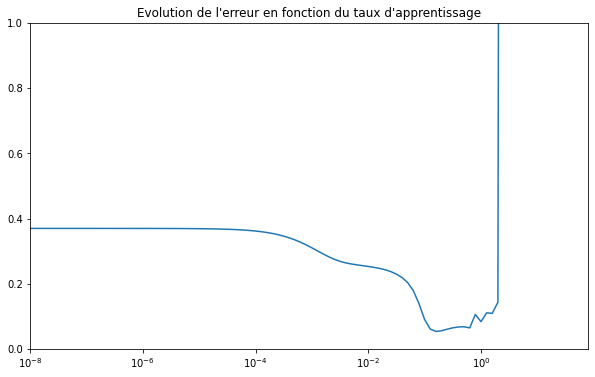

In [45]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 1])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

**3. Entrainement du modèle**

In [46]:
# Charge les meilleurs poids
model.load_weights("poids.hdf5")

In [55]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

cb = TimingCallback()

# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.1,
    decay_steps=10,
    decay_rate=0.1)


# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(learning_rate=1e-1,momentum=0.9)
#optimiseur=tf.keras.optimizers.SGD(learning_rate=lr_schedule,momentum=0.9)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset_norm,validation_data=dataset_Val_norm, epochs=500,verbose=1, callbacks=[CheckPoint,cb])

print(cb.logs)
print(sum(cb.logs))

Epoch 1/500
30/30 [==============================] - 4s 38ms/step - loss: 0.0134 - mae: 0.1222 - val_loss: 0.0193 - val_mae: 0.1499

Epoch 00001: loss improved from inf to 0.01727, saving model to poids.hdf5
Epoch 2/500
30/30 [==============================] - 0s 11ms/step - loss: 0.0283 - mae: 0.1745 - val_loss: 0.2882 - val_mae: 0.7081

Epoch 00002: loss did not improve from 0.01727
Epoch 3/500
30/30 [==============================] - 0s 12ms/step - loss: 0.2166 - mae: 0.5682 - val_loss: 0.5438 - val_mae: 1.0029

Epoch 00003: loss did not improve from 0.01727
Epoch 4/500
30/30 [==============================] - 0s 11ms/step - loss: 0.3980 - mae: 0.8138 - val_loss: 0.9823 - val_mae: 1.4779

Epoch 00004: loss did not improve from 0.01727
Epoch 5/500
30/30 [==============================] - 0s 11ms/step - loss: 0.3183 - mae: 0.7248 - val_loss: 0.6731 - val_mae: 1.1464

Epoch 00005: loss did not improve from 0.01727
Epoch 6/500
30/30 [==============================] - 0s 11ms/step - loss

KeyboardInterrupt: ignored

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

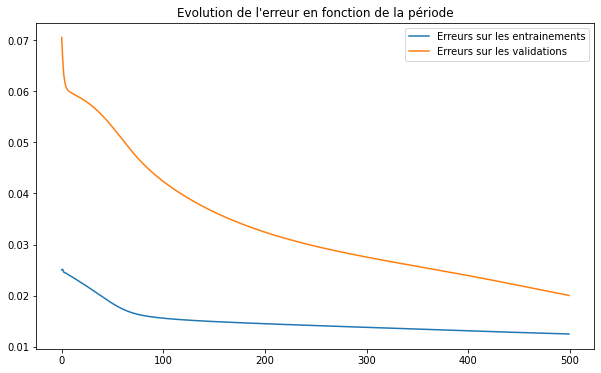

In [49]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

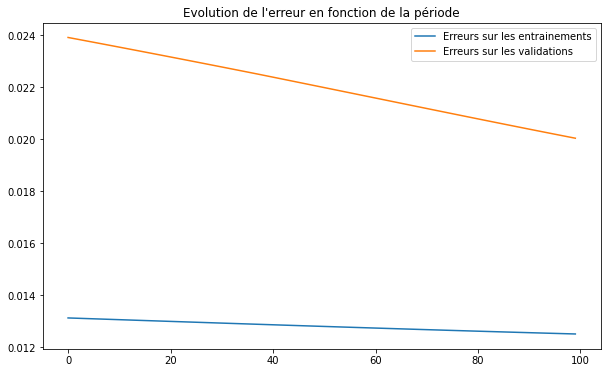

In [50]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_entrainement[400:500], label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_validation[400:500], label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**4. Prédictions**

In [51]:
dataPredict = prepare_dataset_XY_Paquets(x_validation_norm,taille_fenetre,Nbr_Sequences, batch_size, buffer_melange)

predictions = model.predict(dataPredict)
predictions = tf.reshape(predictions,shape=(predictions.shape[0],1))

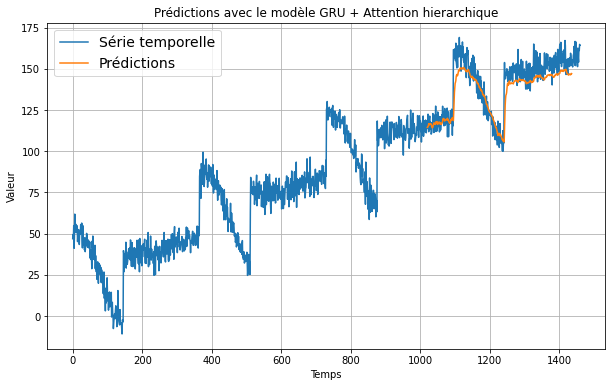

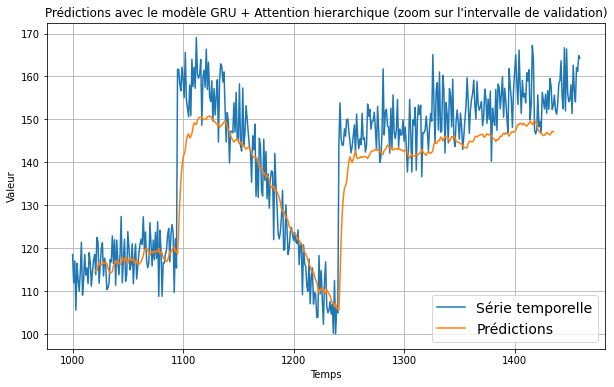

In [52]:
delta = taille_fenetre*Nbr_Sequences
reste = len(temps[temps_separation+delta:])-predictions.shape[0]

# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")

if reste != 0:
  affiche_serie(temps[temps_separation+delta:-reste],np.asarray(predictions*std.numpy()+mean.numpy()),label="Prédictions")
else :
  affiche_serie(temps[temps_separation+delta:],np.asarray(predictions*std.numpy()+mean.numpy()),label="Prédictions")


plt.title('Prédictions avec le modèle GRU + Attention hierarchique')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
if reste != 0:
  affiche_serie(temps[temps_separation+delta:-reste],np.asarray(predictions*std.numpy()+mean.numpy()),label="Prédictions")
else :
  affiche_serie(temps[temps_separation+delta:],np.asarray(predictions*std.numpy()+mean.numpy()),label="Prédictions")
plt.title("Prédictions avec le modèle GRU + Attention hierarchique (zoom sur l'intervalle de validation)")
plt.show()

In [ ]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+delta:-reste],np.asarray(predictions[:,0]*std.numpy()+mean.numpy())).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+delta:-reste],np.asarray(predictions[:,0]*std.numpy()+mean.numpy())).numpy()

print(mae)
print(mse)